In [1]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from os import chdir as cd
import time
import fiona
#import statsmodels.api as sm
from pathlib import Path
%matplotlib inline
import glob

C:\Users\uttar\anaconda3\envs\geopandasenv\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
US_places = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
# source: https://gis.stackexchange.com/questions/141580/which-projection-is-best-for-mapping-the-contiguous-united-states
US_places = US_places.to_crs('EPSG:9311')
US_places.shape

(32188, 17)

In [3]:
# import Mann_kendall analysis data found from MK_trend_national
# for all places in the US
places_attr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\mktest_place_10-20_Continued_labeled.csv')
places_attr['P_19'] = places_attr['Pop_estimate'].str.split(',').str[-2].str.strip('[]').astype(float)
places_attr.rename(columns = {'NAME_x': 'NAME'}, inplace = True)
# slicing column value to match with shapefile for joining
places_attr['GEOID'] = places_attr['GEO_ID'].str.slice(-7)
places_attr['State'] = places_attr['GEOID'].str[:2]
# places_attr = places_attr[places_attr['State'] == state_code]
#places_attr.head()

In [4]:
# joining tabular data with spatial data # by merging the data files based on column name
# use 'outer' join and check unmatched datanames
places_merged_all = US_places.merge(places_attr.loc[:,['GEOID','Pop_estimate', 'P_19', 'P_20', 'trend','label', 'State']],
                                    on = 'GEOID', 
                                    how = 'outer', 
                                    indicator=True)

places_merged = places_merged_all[places_merged_all['_merge'] == 'both']
places_merged.shape

# Excluding Puerto Rico since the forecast do not have values for Puerto Rico
places_merged = places_merged[places_merged['STATEFP'] != '72']

# places that exist in the geographic file (US_places) but not in population data these are places that changed NAME, GEOID or Both or merged or dropped
# they will be checked manually and analyzed separately
# places_merged_all[places_merged_all['_merge'] == 'left_only'].sort_values('NAME').groupby(['STATEFP']).agg({'GEOID':'count',
#                                                                                                             'P_19':'sum',
#                                                                                                             'P_20':'sum'}).sum()

# places_merged_all[places_merged_all['_merge'] == 'left_only'][['GEOID', 'NAME', 'NAMELSAD','Pop_estimate',]]

# source: https://stackoverflow.com/questions/71539030/trying-to-convert-list-values-to-float-in-a-dataframe-with-python
import ast
places_merged['P_18'] = places_merged['Pop_estimate'].apply(ast.literal_eval).str[-3]
places_merged['P_17'] = places_merged['Pop_estimate'].apply(ast.literal_eval).str[-4]
places_merged['P_16'] = places_merged['Pop_estimate'].apply(ast.literal_eval).str[-5]
places_merged['P_15'] = places_merged['Pop_estimate'].apply(ast.literal_eval).str[-6]

In [5]:
# combining the dataframes
# defining the function arguments for data processing
path = r"D:\Work\Box Sync\Trends_all states\County Population\\"
pattern = "ACSDP5Y" + "*.DP05-Data.csv" # file name pattern to list and read them
column_name = 'DP05_0001E'
file_header = [0,1] 
# List of the files that match the pattern
population_files = glob.glob(path + pattern) # listing file names with the pattern
# the file has two headers, deleting the 2nd header and renaming columns to more understandable form
files_map = map(lambda filename: pd.read_csv(filename, index_col = None, usecols = ['GEO_ID', 'NAME','DP05_0001E'], header = 0, engine='python'), population_files)
listofFiles = list(files_map)

for i in range(len(listofFiles)):
    globals()[f"df_{i}"] = listofFiles[i]
    
county_population = df_0.merge(df_1.merge(df_2.merge(df_3.merge(df_4.merge(df_5, on = 'GEO_ID' , how = 'outer', suffixes = ('_19', '_20')),
                                                                on = 'GEO_ID' , how = 'outer', suffixes = ('_18', '_19')), 
                                                     on = 'GEO_ID' , how = 'outer', suffixes = ('_17', '_18')),
                                          on = 'GEO_ID' , how = 'outer', suffixes = ('_16', '_17')), 
                               on = 'GEO_ID' , how = 'outer', suffixes = ('_15', '_16'))

county_population = county_population.tail(-1)

county_population[['DP05_0001E_15', 'DP05_0001E_16','DP05_0001E_17', 
              'DP05_0001E_18', 'DP05_0001E_19', 'DP05_0001E_20']] = county_population[['DP05_0001E_15', 'DP05_0001E_16',
                                                                        'DP05_0001E_17', 'DP05_0001E_18', 'DP05_0001E_19', 
                                                                        'DP05_0001E_20']].astype(float)

In [6]:
# loading forecasted population data from Hauer
%cd "D:\Work\Box Sync\Depop Population forecasting\NASA SEDAC data\county_projectios_Total_bySex_byRace\total_pop_proj"
county_Projection = gpd.read_file(r"hauer_county_totpop_SSPs.shp")

# contains 3221 rows, 3135 rows contains forecast values, these 3135 rows will be used for analysis
county_Projection.shape
# 78 rows with zero data for counties in Puerto Rico
# county_Projection[county_Projection['STATEFP10'] == '72']
county_Projection = county_Projection[county_Projection['ssp32020'] != 0]
# check coordinate system and project to similar coordinate system
# to change the coordinate system
county_Projection = county_Projection.to_crs('3528')
if county_Projection.crs != places_merged.crs:
    places_merged = places_merged.to_crs(county_Projection.crs)

    
#county_population['Estimate!!SEX AND AGE!!Total population'] = county_population['Estimate!!SEX AND AGE!!Total population'].astype('float')
county_population['GEOID10'] = county_population['GEO_ID'].str.slice(-5)
county_Projection = county_Projection.merge(county_population, on = 'GEOID10')

# # county_Projection['diff'] = ((county_Projection['ssp32020'] - county_Projection['DP05_0001E_20'] )/ county_Projection['DP05_0001E_20']).round(3)
# county_Projection[['STATEFP10', 'GEOID10', 'NAME10','NAME_15', 'ssp32020', 
#                    'DP05_0001E_19', 'DP05_0001E_20', 'diff']].sort_values('diff', ascending = True)

county_population.shape, county_Projection.shape, county_population.columns

D:\Work\Box Sync\Depop Population forecasting\NASA SEDAC data\county_projectios_Total_bySex_byRace\total_pop_proj


((3222, 14),
 (3135, 117),
 Index(['GEO_ID', 'NAME_15', 'DP05_0001E_15', 'NAME_16', 'DP05_0001E_16',
        'NAME_17', 'DP05_0001E_17', 'NAME_18', 'DP05_0001E_18', 'NAME_19',
        'DP05_0001E_19', 'NAME_20', 'DP05_0001E_20', 'GEOID10'],
       dtype='object'))

In [7]:
places_merged['diff'] = ((places_merged['P_20'] - places_merged['P_15'] )/ places_merged['P_15']).round(3)
places_merged[['STATEFP', 'GEOID', 'NAMELSAD', 'P_20','P_19',
        'P_15', 'P_16', 'P_17','P_18']].isna().sum() #sort_values('diff', ascending = True)

check_places_df = places_merged[['STATEFP', 'GEOID', 'NAMELSAD', 'P_20','P_19',
        'P_15', 'P_16', 'P_17','P_18']]
num = 0
for i in check_places_df.columns:
    num += check_places_df[i][check_places_df[i]==0].count()
num

1266

In [8]:
combined_df = pd.DataFrame()
gdf = pd.DataFrame()

for state in county_Projection['STATEFP10'].sort_values().unique():
    # print('start...')
    # print('........')
    population_projection =  county_Projection[county_Projection['STATEFP10'] == state]
    places_population = places_merged[places_merged['STATEFP'] == state]
    
    # print(population_projection.head())
    # print('........')
    # print(places_population.head())
    
    if population_projection.crs == places_population.crs:
        # calculating total area from geometry # try using land/water ratio???? # didnt use geom_area, used ALAND area
        geom_overlayed = gpd.overlay(population_projection, places_population, how='intersection', keep_geom_type=False, make_valid=True)

        geom_overlayed['intersect_area'] = geom_overlayed.area
    
        geom_overlayed['%area'] = geom_overlayed['intersect_area'] /geom_overlayed['ALAND'] 
        geom_overlayed['area_factor'] = geom_overlayed.groupby(by = ['GEOID'])['%area'].apply(lambda x:(x/x.sum()))
        geom_overlayed['landarea'] = geom_overlayed['ALAND'] / (1000*1000)
        
        year = ['15', '16', '17', '18', '19', '20']
        for i in year:
            place_column_name = 'P_' + str(i)
            county_column_name = 'DP05_0001E_' + str(i)
            density = 'density_' + str(i)
            P_adjusted = 'P_adjusted' + str(i)
            # density in km2
            geom_overlayed[density] = geom_overlayed[place_column_name]/geom_overlayed['landarea'] 
            geom_overlayed[P_adjusted] = geom_overlayed['area_factor'] * geom_overlayed[density] * geom_overlayed['landarea']
            # what percent of county population lives in this place
            column_name = 'population_factor_' + str(i)
            geom_overlayed[column_name] = geom_overlayed[P_adjusted] / geom_overlayed[county_column_name]
            print('missing factors for year 20' + str(i) + ' in state ' + str(state) + ':  ' + str(geom_overlayed[column_name].isna().sum()))
            print('dataframe shape:')
            print(geom_overlayed.shape)
            
        gdf = pd.concat([gdf, geom_overlayed], axis=0, ignore_index=True)
            # gdf = gdf.reset_index(drop= True)
    print('missing factors for year 20' + str(i) + ' in state ' + str(state) + ':  ' + str(gdf[column_name].isna().sum()))
    print('dataframe shape:')
    print(gdf.shape)


missing factors for year 2015 in state 01:  0
dataframe shape:
(706, 152)
missing factors for year 2016 in state 01:  0
dataframe shape:
(706, 155)
missing factors for year 2017 in state 01:  0
dataframe shape:
(706, 158)
missing factors for year 2018 in state 01:  0
dataframe shape:
(706, 161)
missing factors for year 2019 in state 01:  0
dataframe shape:
(706, 164)
missing factors for year 2020 in state 01:  0
dataframe shape:
(706, 167)
missing factors for year 2020 in state 01:  0
dataframe shape:
(706, 167)
missing factors for year 2015 in state 02:  0
dataframe shape:
(323, 152)
missing factors for year 2016 in state 02:  0
dataframe shape:
(323, 155)
missing factors for year 2017 in state 02:  0
dataframe shape:
(323, 158)
missing factors for year 2018 in state 02:  0
dataframe shape:
(323, 161)
missing factors for year 2019 in state 02:  0
dataframe shape:
(323, 164)
missing factors for year 2020 in state 02:  26
dataframe shape:
(323, 167)
missing factors for year 2020 in stat

In [9]:
geom_overlayed.isna().sum()

STATEFP10               0
COUNTYFP10              0
COUNTYNS10              0
GEOID10                 0
NAME10                  0
                       ..
P_adjusted19            0
population_factor_19    0
density_20              0
P_adjusted20            0
population_factor_20    0
Length: 167, dtype: int64

In [10]:
gdf.isna().sum()

STATEFP10                0
COUNTYFP10               0
COUNTYNS10               0
GEOID10                  0
NAME10                   0
                        ..
P_adjusted19             0
population_factor_19     0
density_20               0
P_adjusted20             0
population_factor_20    26
Length: 167, dtype: int64

In [11]:
gdf.shape
# geom_overlayed[['STATEFP10', 'STATEFP10', 'NAMELSAD',  '%area', 'P_adjusted20',
#                       'P_20','landarea', 'density_20', 'population_factor_20',
#                        'DP05_0001E_20', 'DP05_0001E_15', 'population_factor_15',]]

(33646, 167)

In [12]:
# check_null_gdf =gdf[['STATEFP10', 'STATEFP10', 'NAMELSAD',  '%area', 'P_adjusted20',
#                       'P_20','landarea', 'density_20', 'population_factor_20',
#                        'DP05_0001E_20', 'DP05_0001E_15', 'population_factor_15',]]
# null_gdf = check_null_gdf[check_null_gdf.isnull().any(axis=1)]
# null_gdf #[null_gdf['%area'] >1]

In [13]:
gdf_grouped = gdf.groupby(['STATEFP','NAMELSAD']).agg({'P_20': 'first', 'P_19': 'first', 'P_18': 'first',
                                       'P_17': 'first', 'P_16': 'first', 'P_15': 'first',
                                       'population_factor_20': 'sum', 'population_factor_19': 'sum',
                                       'population_factor_18': 'sum', 'population_factor_17': 'sum',
                                       'population_factor_16': 'sum', 'population_factor_15': 'sum',
                                       'DP05_0001E_20': 'first', 'DP05_0001E_19': 'first',
                                       'DP05_0001E_18': 'first', 'DP05_0001E_17': 'first',
                                       'DP05_0001E_16': 'first', 'DP05_0001E_15': 'first'}).reset_index()
                                       
gdf_grouped.shape                                   

(28891, 20)

In [14]:
# # places_merged[['STATEFP', 'NAMELSAD','P_20', 'P_19']].sort_values('NAMELSAD')
# gdf.groupby(['STATEFP','NAMELSAD10','NAMELSAD', ]).agg({'area_factor': 'sum', 'P_20': 'first', 'P_19': 'first', 'P_18': 'first',
#                                        'P_17': 'first', 'P_16': 'first', 'P_15': 'first',
#                                        'population_factor_20': 'sum', 'population_factor_19': 'sum',
#                                        'population_factor_18': 'sum', 'population_factor_17': 'sum',
#                                        'population_factor_16': 'sum', 'population_factor_15': 'sum',}).sort_values(['STATEFP', 'NAMELSAD10'])

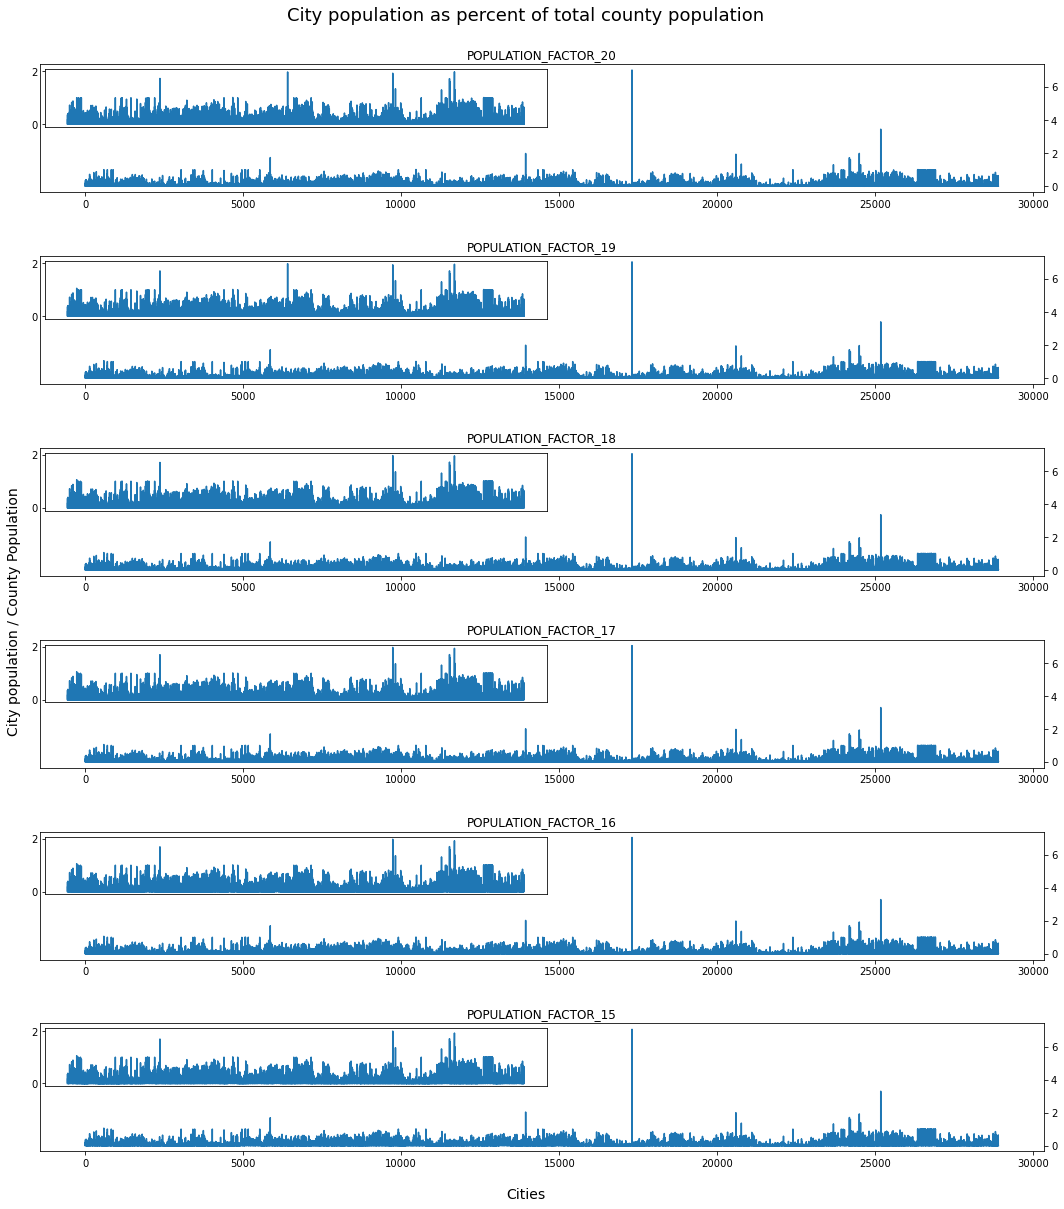

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

col_names = ['population_factor_20', 'population_factor_19', 'population_factor_18',
             'population_factor_17', 'population_factor_16','population_factor_15'] # 

fig  = plt.figure(figsize=(18,20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("City population as percent of total county population", fontsize=18, y=.92)

# loop through the length of tickers and keep track of index
for n, col in enumerate(col_names):
    # add a new subplot iteratively
    ax = plt.subplot(6, 1, n + 1)
    ax1 = inset_axes(ax, width="50%", height=0.8, loc=2)

    # filter df and plot ticker on the new subplot axis
    # gdf[col].plot(ax=ax) 
    gdf_grouped[col].plot(ax=ax)
    gdf_grouped[gdf_grouped[col]<2][col].plot(ax=ax1)

    # chart formatting
    ax.set_title(col.upper())
    ax.set_xlabel("")
    ax.yaxis.tick_right()
    
    # ax1.set_title('for values less than 1')
    
    ax1.set_xticks([])
fig.supxlabel('Cities', fontsize=14, y=0.09)
fig.supylabel('City population / County Population', fontsize=14, x=0.1)
plt.show()

fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\Plot cityPop as percent countyPop all years.png', dpi = 300, #  all years
           bbox_inches='tight', transparent="True", pad_inches=0)

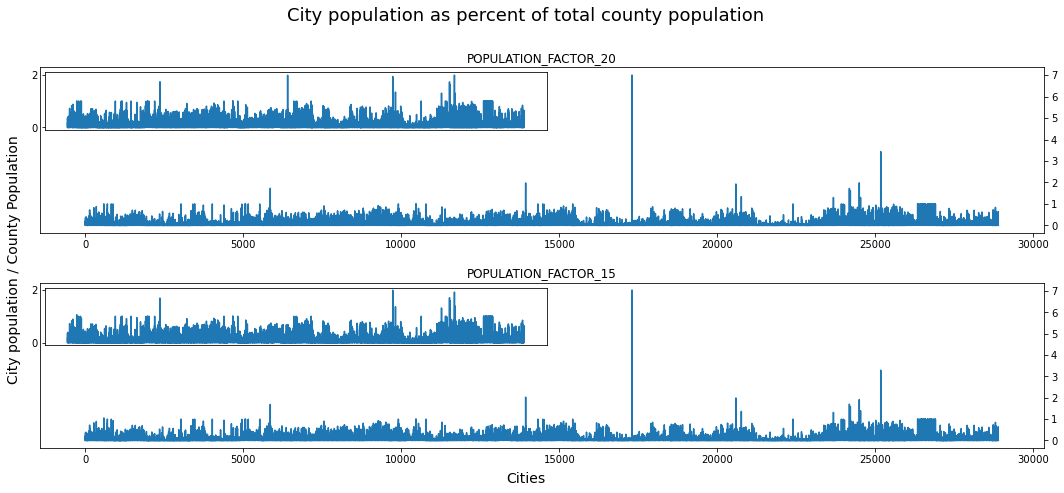

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

col_names = ['population_factor_20', 'population_factor_15'] # 

fig  = plt.figure(figsize=(18,7))
plt.subplots_adjust(hspace=0.3)
plt.suptitle("City population as percent of total county population", fontsize=18, y=1)

# loop through the length of tickers and keep track of index
for n, col in enumerate(col_names):
    # add a new subplot iteratively
    ax = plt.subplot(2, 1, n + 1)
    ax1 = inset_axes(ax, width="50%", height=0.8, loc=2)

    # filter df and plot ticker on the new subplot axis
    # gdf[col].plot(ax=ax) 
    gdf_grouped[col].plot(ax=ax)
    gdf_grouped[gdf_grouped[col]<2][col].plot(ax=ax1)

    # chart formatting
    ax.set_title(col.upper())
    ax.set_xlabel("")
    ax.yaxis.tick_right()
    
    # ax1.set_title('for values less than 1')
    
    ax1.set_xticks([])
fig.supxlabel('Cities', fontsize=14, y=0.05)
fig.supylabel('City population / County Population', fontsize=14, x=0.1)
plt.show()

fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\Plot cityPop as percent countyPop.png', dpi = 300, #  all years
           bbox_inches='tight', transparent="True", pad_inches=0)